# CNN with XGBoost for FC Layer

In [40]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data.sampler import SubsetRandomSampler # for validation testing
import matplotlib.pyplot as plt
import xgboost

In [81]:
fashion_mnist = datasets.FashionMNIST('~./data', download=False, train=True).train_data.float()
transform = transforms.Compose([ transforms.Resize((224, 224)),
                                         transforms.ToTensor(), 
                                         transforms.Normalize((fashion_mnist.mean()/255,), (fashion_mnist.std()/255,))])
train_set = datasets.FashionMNIST('~./data', download=False, train = True, transform = transform)
test_set = datasets.FashionMNIST('~./data', download=False, train = False, transform = transform)

# train validation split:
indices = list(range(len(train_set)))
np.random.shuffle(indices)

split = int(np.floor(.2 * len(train_set)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

# Data Loaders:
train_loader = torch.utils.data.DataLoader(train_set, sampler = train_sample, batch_size = 32) # note that sampler is mutually exclusive with shuffle
valid_loader = torch.utils.data.DataLoader(train_set, sampler = train_sample, batch_size = 32)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 128)

/home/janhsc/miniconda3/envs/MachineLearning/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


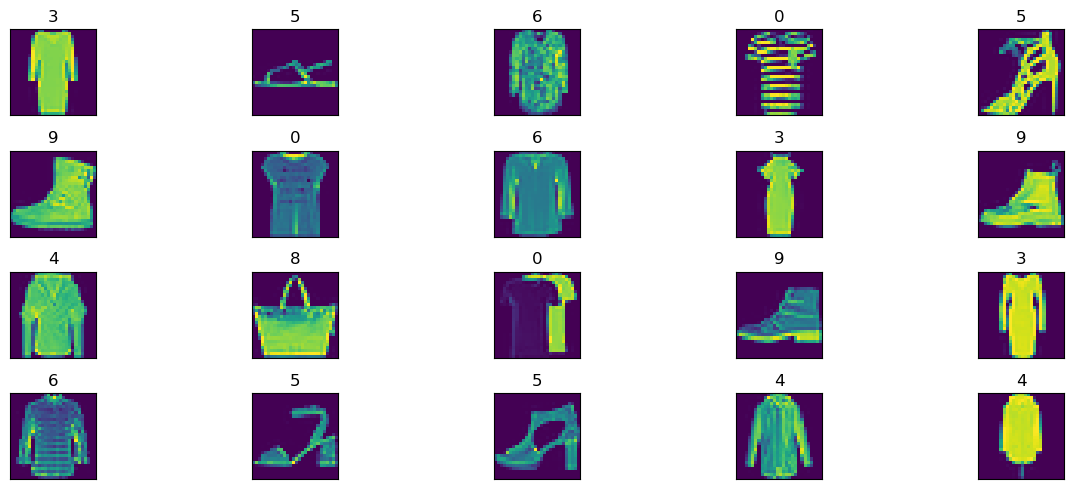

In [22]:
trainiter = iter(train_loader)
images, labels = next(trainiter)
print(images.size())
fig = plt.figure(figsize = (15, 5))
for idx in np.arange(20):
    ax = fig.add_subplot(4, int(20/4), idx + 1, xticks = [], yticks = [])
    ax.imshow(np.squeeze(images[idx]))
    ax.set_title(labels[idx].item())
    fig.tight_layout()

In [63]:
if torch.cuda.is_available(): print('CUDA is available. Things are going to be fast')
else: print('No CUDA :( Things will be slow')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available. Things are going to be fast


## Transfer Learning for Comparison

In [64]:
weights = ResNet50_Weights.DEFAULT
preprocess = weights.transforms()

In [65]:
class AdaptedResNet(nn.Module):
    def __init__(self, in_channels = 1):
        super(AdaptedResNet, self).__init__()

        self.model = resnet50(weights = weights)
        self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size = 7, stride = 2, padding = 3, bias = False)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 10)
    def forward(self, x):
        return self.model(x)

In [66]:
import copy
def train_eval(model, n_epochs = 10, eta = .001, momentum = .9,
               trainloader = train_loader, testloader = test_loader):
    """
    Trains and evaluates model. The train& test loss and the train& test accuracy
    of each epoch are printed. The model with the highest epoch test accuracy is 
    returned
    
    Args:
        model: pretrained network to finetune
        n_epochs (int): number of epochs
        eta (float): learning rate
        momentum (float): momentum
        trainloader (torch.utils.data.DataLoader): DataLoader with train data
        testloader (torch.utils.data.DataLoader): DataLoader with test data
    Returns:
        Model with the highest epoch test accuracy.
    """
    optimizer = torch.optim.SGD(model.parameters(), lr = eta,
                                momentum = momentum)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loss = torch.nn.CrossEntropyLoss()

    train_loss, train_acc = [], []
    test_loss, test_acc = [], []
    best_test_acc = 0.0


    print("-------------------------------------------------------------------")
    for epoch in range(n_epochs):
        running_train_loss = 0.0
        running_test_loss = 0.0
        correct_train = 0


        # training process
        for x, t in trainloader:
          optimizer.zero_grad()
          z = model(x.to(device))
          J_train = loss(z, t.to(device))
          J_train.backward()
          optimizer.step()
          correct_train += torch.sum(torch.argmax(z, dim = 1) == t.to(device)).item()
          running_train_loss += J_train.item()*x.size(0)
        train_acc_ep = correct_train/trainloader.dataset.data.shape[0]
        train_loss_ep = running_train_loss/trainloader.dataset.data.shape[0]
        train_loss.append(train_loss_ep)
        train_acc.append(train_acc_ep)


        # testing process
        with torch.no_grad():
          correct_test = 0
          for x, t in testloader:
            z = model(x.to(device))
            J_test = loss(z, t.to(device))
            correct_test += torch.sum(torch.argmax(z, dim = 1)==t.to(device)).item()
            running_test_loss += J_test.item()*x.to(device).size(0)
          test_acc_ep = correct_test/testloader.dataset.data.shape[0]
          test_loss_ep = running_test_loss/testloader.dataset.data.shape[0]
          test_acc.append(test_acc_ep)
          test_loss.append(test_loss_ep)
          if test_acc_ep > best_test_acc:
            best_test_acc = test_acc_ep
            best_model_weights = copy.deepcopy(model.state_dict())
        

        # print accuracies and losses for current epoch
        print(f"Epoch {epoch+1}/{n_epochs}:\n"
        f"\t train accuracy:\t{train_acc_ep:.3f}\t test accuracy:\t{test_acc_ep:.3f}\n"
        f"\t train loss:\t\t{J_train.item():.3f}\t test loss:\t{J_test.item():.3f}")
    print("-------------------------------------------------------------------")
    model.load_state_dict(best_model_weights)
    return model

In [67]:
transfer_network = AdaptedResNet()
train_eval(transfer_network)

-------------------------------------------------------------------
Epoch 1/10:
	 train accuracy:	0.128	 test accuracy:	0.809
	 train loss:		0.436	 test loss:	0.421
Epoch 2/10:
	 train accuracy:	0.168	 test accuracy:	0.858
	 train loss:		0.428	 test loss:	0.270
Epoch 3/10:
	 train accuracy:	0.175	 test accuracy:	0.879
	 train loss:		0.116	 test loss:	0.236
Epoch 4/10:
	 train accuracy:	0.180	 test accuracy:	0.888
	 train loss:		0.394	 test loss:	0.260
Epoch 5/10:
	 train accuracy:	0.182	 test accuracy:	0.892
	 train loss:		0.271	 test loss:	0.161
Epoch 6/10:
	 train accuracy:	0.186	 test accuracy:	0.893
	 train loss:		0.041	 test loss:	0.160
Epoch 7/10:
	 train accuracy:	0.188	 test accuracy:	0.904
	 train loss:		0.085	 test loss:	0.192
Epoch 8/10:
	 train accuracy:	0.191	 test accuracy:	0.902
	 train loss:		0.127	 test loss:	0.152
Epoch 9/10:
	 train accuracy:	0.193	 test accuracy:	0.903
	 train loss:		0.133	 test loss:	0.138
Epoch 10/10:
	 train accuracy:	0.195	 test accuracy:	0.906


AdaptedResNet(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [ ]:
models_ensemble = [models.resnet50().to(device), models.resnet50().to(device)]
predictions = [F.softmax(m(torch.rand(1,3,224,244).to(device))) for m in models_ensemble] 
avg_prediction = torch.stack(predictions).mean(0).argmax()